## Introduction

This is my notebook I used to explore the NYC Taxi Fare dataset. We predict the fare amount based on the provided features.

### Import necessary libraries


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import skew
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from datetime import datetime


load the data saved from notebook 'Part 1-EDA'

In [2]:
df = pd.read_csv('data.csv', index_col='Unnamed: 0')

C:\Users\Nastaran\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount
1,6D3B2A7682C30DCF64F3F12976EF93B6,A603A9D5FAA46E8FF2A97A143328D938,CMT,1,2013-08-30 23:26:23,2013-08-30 23:46:01,2,1177,11.0,-73.862724,40.769062,-73.976845,40.764595,CSH,31.0,0.5,0.5,0.0,5.33
2,6D49E494913752B75B2685E0019FF3D5,3F0BFE90A5D71741840B25600A89E225,CMT,1,2013-08-30 09:18:10,2013-08-30 09:24:08,1,357,0.8,-73.991653,40.750324,-73.986420,40.742924,CSH,5.5,0.0,0.5,0.0,0.00
3,4C4A0AFC432A1A87E97ED8F18403FF6E,BA20A20E2CF85EF7B00162D711394C7E,CMT,1,2013-08-26 23:27:11,2013-08-26 23:42:49,4,938,7.7,-73.975372,40.756237,-73.867119,40.721886,CSH,23.0,0.5,0.5,0.0,5.33
4,1258CA1DF5E2A9E9A9F7848408A7AAEB,8C14DCF69CAA2A9A0DFAFD99E00536A1,CMT,1,2013-08-29 10:57:56,2013-08-29 11:19:06,2,1270,2.1,-73.991020,40.750912,-73.996727,40.767578,CSH,14.0,0.0,0.5,0.0,0.00
5,3B0E8DC736D1E0D35C698D7B0BF9CBFA,95E1B89BC718FB1DC76B939937E043F3,CMT,1,2013-08-27 11:37:45,2013-08-27 12:00:58,1,1392,10.9,-73.872948,40.774212,-73.981438,40.743946,CSH,31.5,0.0,0.5,0.0,5.33


In [4]:
print('Total data size is {}'.format(df.shape))


Total data size is (11409583, 19)


In [5]:
df.isnull().any().sum()

0

In [6]:
df.dtypes

medallion             object
hack_license          object
vendor_id             object
rate_code              int64
pickup_datetime       object
dropoff_datetime      object
passenger_count        int64
trip_time_in_secs      int64
trip_distance        float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
payment_type          object
fare_amount          float64
surcharge            float64
mta_tax              float64
tip_amount           float64
tolls_amount         float64
dtype: object

In [7]:
df['rate_code'] = df['rate_code'].astype(str)


Lets have a look to the target variable, fare amount


 mu = 12.48 and sigma = 9.93



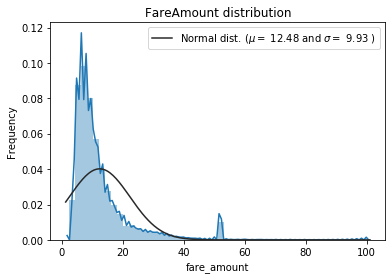

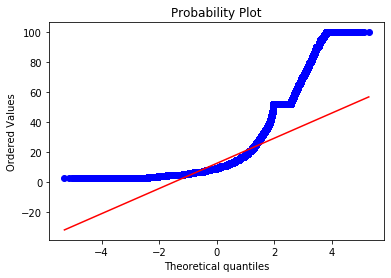

Skewness: 2.679353
Kurtosis: 9.044000


In [8]:
# Plot Histogram
sns.distplot(df['fare_amount'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['fare_amount'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('FareAmount distribution')

fig = plt.figure()
res = stats.probplot(df['fare_amount'], plot=plt)
plt.show()

print("Skewness: %f" % df['fare_amount'].skew())
print("Kurtosis: %f" % df['fare_amount'].kurt())

Looks like a normal distribution? Not quite! Looking at the kurtosis score, we can see that there is a very nice peak. However, looking at the skewness score, we can see that the sale prices deviate from the normal distribution

Based on discussion in notebook Part 2, we consider the maximum tip as 20USD.

In [9]:
df = df[df['tip_amount']<21]

### Including date-time features


In [10]:
df['pickup_datetime']  = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']  = pd.to_datetime(df['dropoff_datetime'])

In [11]:
# Datetime features (hour of day, day of week)
pickup = df['pickup_datetime']
dropoff = df['dropoff_datetime']
df['pickup_hour'] = pickup.apply(lambda i: i.hour)
df['pickup_day'] = pickup.apply(lambda i: i.dayofweek)
df['dropoff_hour'] = dropoff.apply(lambda i: i.hour)
df['dropoff_day'] = dropoff.apply(lambda i: i.dayofweek)


In [12]:
print('Total data size is {}'.format(df.shape))


Total data size is (11405549, 23)


### Data Preparation

In [13]:
df.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,pickup_hour,pickup_day,dropoff_hour,dropoff_day
1,6D3B2A7682C30DCF64F3F12976EF93B6,A603A9D5FAA46E8FF2A97A143328D938,CMT,1,2013-08-30 23:26:23,2013-08-30 23:46:01,2,1177,11.0,-73.862724,...,CSH,31.0,0.5,0.5,0.0,5.33,23,4,23,4
2,6D49E494913752B75B2685E0019FF3D5,3F0BFE90A5D71741840B25600A89E225,CMT,1,2013-08-30 09:18:10,2013-08-30 09:24:08,1,357,0.8,-73.991653,...,CSH,5.5,0.0,0.5,0.0,0.00,9,4,9,4
3,4C4A0AFC432A1A87E97ED8F18403FF6E,BA20A20E2CF85EF7B00162D711394C7E,CMT,1,2013-08-26 23:27:11,2013-08-26 23:42:49,4,938,7.7,-73.975372,...,CSH,23.0,0.5,0.5,0.0,5.33,23,0,23,0
4,1258CA1DF5E2A9E9A9F7848408A7AAEB,8C14DCF69CAA2A9A0DFAFD99E00536A1,CMT,1,2013-08-29 10:57:56,2013-08-29 11:19:06,2,1270,2.1,-73.991020,...,CSH,14.0,0.0,0.5,0.0,0.00,10,3,11,3
5,3B0E8DC736D1E0D35C698D7B0BF9CBFA,95E1B89BC718FB1DC76B939937E043F3,CMT,1,2013-08-27 11:37:45,2013-08-27 12:00:58,1,1392,10.9,-73.872948,...,CSH,31.5,0.0,0.5,0.0,5.33,11,1,12,1


we get randome samples of df

In [14]:
ds = df.sample(200000)

In [15]:
correlation = ds.corr()


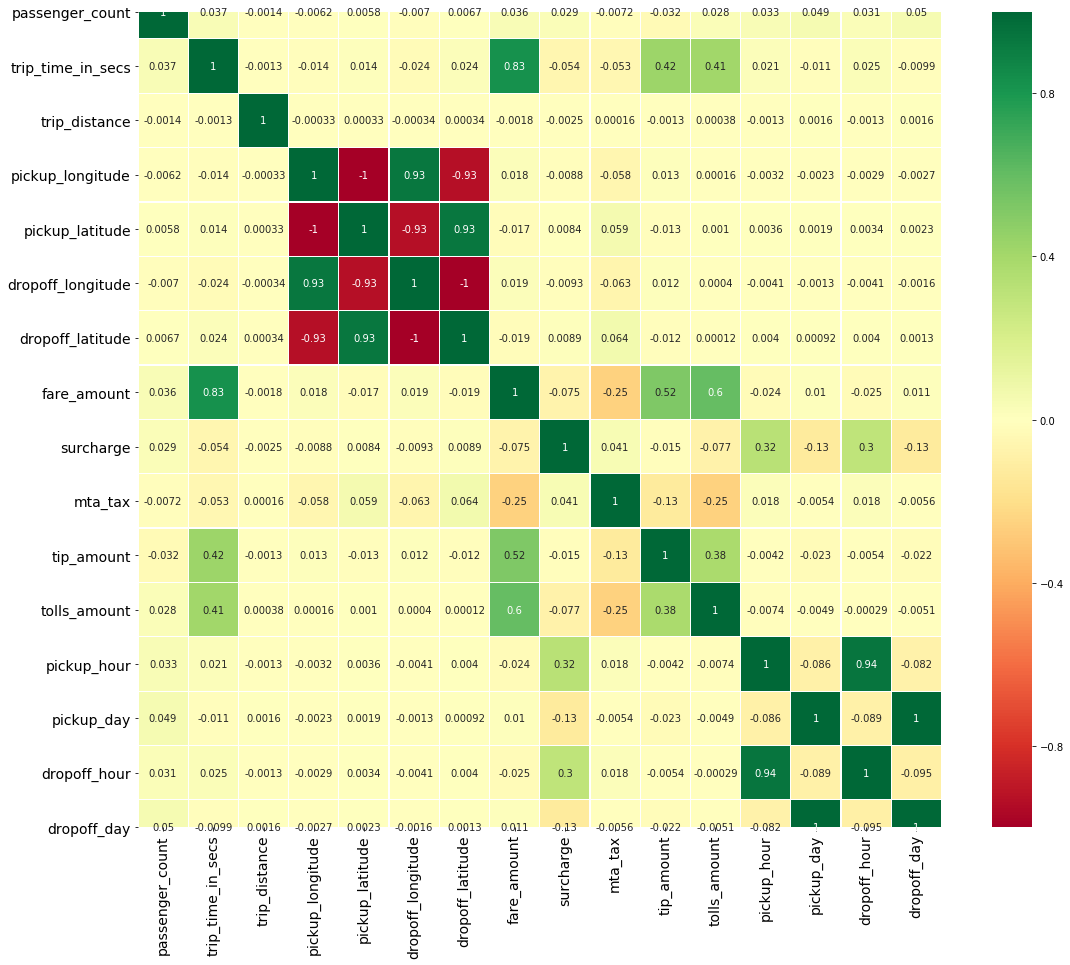

In [16]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

We drop those features which are highly correlated

In [17]:
ds = ds.drop(['pickup_datetime','dropoff_datetime', 'pickup_latitude','dropoff_longitude','dropoff_latitude','dropoff_hour','dropoff_day'], axis =1 )

Define target and the features

In [18]:
y = ds['fare_amount']
x = ds.drop(['fare_amount'], axis =1 )

In [19]:
x = x.set_index(['medallion', 'hack_license'])


In [20]:
x.head()

,,vendor_id,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,payment_type,surcharge,mta_tax,tip_amount,tolls_amount,pickup_hour,pickup_day
medallion,hack_license,,,,,,,,,,,,,
8EFE467A2378D86F5E932D16D0BAD84D,BAA45DCE9CBAF175CA0BF49F63E49D3F,CMT,1,1,293,1.00,-73.968391,CRD,0.0,0.5,1.5,0.0,10,3
94A3B588A3B481618BFFA8461DB1FB78,D7151364A40D1B514BB63D9C04B2273A,VTS,1,1,2940,5.46,-73.976707,CRD,0.0,0.5,2.0,0.0,11,2
E74B4A31253AA0B5B01E96915A36B503,4900D6FC1B973139CBC3BEB257E2713D,VTS,1,2,180,0.62,-73.992470,CRD,1.0,0.5,4.0,0.0,18,1
B37FE442AF1F30E7B92F5349F05DC927,8E68E86F3EE7334EAC0496215AC93B7B,CMT,1,3,528,2.90,-73.993401,CSH,0.5,0.5,0.0,0.0,21,0
1C73750A0047CB7553C929BE7571A115,19103D0CAE434737F27CE8C1FED42F26,CMT,1,1,722,1.30,-73.988510,CRD,0.0,0.5,2.0,0.0,11,6


In [21]:
#Features name

features_name = list(x.columns)
features_name

['vendor_id',
 'rate_code',
 'passenger_count',
 'trip_time_in_secs',
 'trip_distance',
 'pickup_longitude',
 'payment_type',
 'surcharge',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'pickup_hour',
 'pickup_day']

In [22]:
# one-hot encoding of categorical variables

x = pd.get_dummies(x)

In [23]:
x = x.drop(['payment_type_UNK','rate_code_1','vendor_id_VTS'], axis =1 )

In [25]:
x_train,x_test, y_train,y_test = train_test_split(x,y, random_state = 20, test_size=0.2)

In [26]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data and transform both training and testing data
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

print('Training data shape: ', x_train.shape)
print('Testing data shape: ', x_test.shape)

Training data shape:  (160000, 20)
Testing data shape:  (40000, 20)


### Building Models

#### Baseline 

To make sure that machine learning is applicable to the task, we should compare these predictions to a baseline model. For a regression task, this can be as simple as the average value of the target in the training data.

In [27]:
train_mean = y_train.mean()


In [28]:
# Create list of the same prediction for every observation
train_preds = [train_mean for _ in range(len(y_train))]
test_preds = [train_mean for _ in range(len(y_test))]

#### Score Model
Here we use the validation set for assessing the model. We'll use two metrics:

* Root mean squared error: the metric used by the competition
* Mean absolute percentage error: the average percentage error of the predictions

In [29]:
#mean squared error
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

In [30]:
print('RMSE: %.3f' % (train_rmse))
print('RMSE: %.3f' % (test_rmse))

RMSE: 9.893
RMSE: 9.916


In [31]:
train_mae = mean_absolute_error(y_train, train_preds)
test_mae = mean_absolute_error(y_test, test_preds)

In [32]:
print('MAE: %.3f' % (train_mae))
print('MAE: %.3f' % (test_mae))

MAE: 6.520
MAE: 6.552


#### First Model: Linear Regression

Wetrain the linear regression using three features. The benefit of the linear regression is that it's interpretable and we can inspect the coefficients and intercept.

In [33]:
x_train = pd.DataFrame(data=x_train, columns=x.columns)

In [34]:
lr = LinearRegression()

In [35]:
lr.fit(x_train[[ 'passenger_count','trip_time_in_secs']], y_train)

print('Intercept', round(lr.intercept_, 4))
print('abs_lat_diff coef: ', round(lr.coef_[0], 4), 
      '\tabs_lon_diff coef:', round(lr.coef_[1], 4))


Intercept 1.5759
abs_lat_diff coef:  0.235 	abs_lon_diff coef: 301.7677


In [36]:
x_test= pd.DataFrame(data=x_test, columns=x.columns)

In [37]:
y_pred = lr.predict(x_test[['passenger_count','trip_time_in_secs']])

In [38]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % (rmse))

RMSE: 5.403


In [39]:
mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % (mae))

MAE: 2.654


Having a decrease in rmse shows that we are in right path

This time we consider all the features

In [40]:
lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
y_pred = lr.predict(x_test)

In [42]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % (rmse))

RMSE: 3.820


In [43]:
mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % (mae))

MAE: 1.997


Text(0.5, 1.0, 'Distribution of Random Forest Predicted Fare Amount')

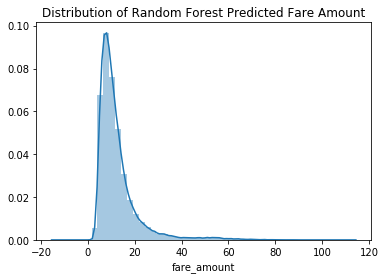

In [44]:
preds = lr.predict(x_test)
test_id = x_test.index

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_rf_simple.csv', index = False)

sns.distplot(sub['fare_amount'])
plt.title('Distribution of Random Forest Predicted Fare Amount')

#### Upgraded Model
When we want to improve performance, we generally have a few options:

* Get more data - either more observations or more variables
* Engineer more / better features
* Perform feature selection to remove irrelevant features
*Try a more complex model
* Perform hyperparameter tuning of the selected model

#### Second Model: Random Forest

In [45]:
# Create the random forest
random_forest = RandomForestRegressor()

# Train on data
random_forest.fit(x_train, y_train)

# predict 
y_pred = random_forest.predict(x_test)

In [46]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % (rmse))

RMSE: 1.602


In [47]:
mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % (mae))

MAE: 0.723


We can plot the predictions as a line and compare it to the original dataset.



In [48]:
x_test

,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,surcharge,mta_tax,tip_amount,tolls_amount,pickup_hour,pickup_day,vendor_id_CMT,rate_code_0,rate_code_2,rate_code_3,rate_code_4,rate_code_5,payment_type_CRD,payment_type_CSH,payment_type_DIS,payment_type_NOC
0,0.000000,0.020105,2.667918e-07,0.113843,0.042017,1.0,0.000000,0.0,0.869565,0.833333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.666667,0.083095,2.032065e-06,0.115070,0.042017,1.0,0.371606,0.0,0.913043,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.000000,0.071633,5.973173e-07,0.113875,0.000000,1.0,0.000000,0.0,0.347826,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.000000,0.014709,1.482177e-07,0.113669,0.084034,1.0,0.000000,0.0,0.782609,0.166667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.000000,0.011461,1.482177e-07,0.113645,0.084034,1.0,0.000000,0.0,0.695652,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.000000,0.035578,2.075048e-07,0.113819,0.042017,1.0,0.142925,0.0,0.608696,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
39996,0.000000,0.040115,7.470172e-07,0.114101,0.000000,1.0,0.000000,0.0,0.565217,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
39997,0.000000,0.057593,7.114449e-07,0.636562,0.042017,1.0,0.226298,0.0,0.956522,0.500000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
39998,0.666667,0.032951,4.446531e-07,0.113690,0.042017,1.0,0.095283,0.0,0.173913,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Distribution of Random Forest Predicted Fare Amount')

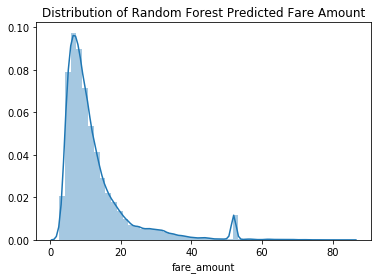

In [49]:
preds = random_forest.predict(x_test)
test_id = x_test.index

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_rf_simple.csv', index = False)

sns.distplot(sub['fare_amount'])
# sns.distplot(y_test)
plt.title('Distribution of Random Forest Predicted Fare Amount')

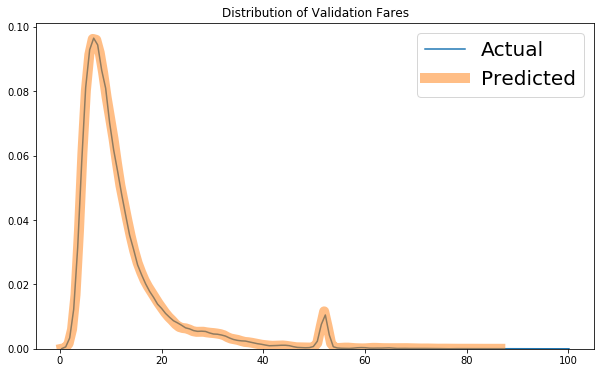

In [50]:
preds = random_forest.predict(x_test)

plt.figure(figsize = (10, 6))
sns.kdeplot(y_test, label = 'Actual')
sns.kdeplot(preds, label = 'Predicted',linewidth=10,alpha=.5)
plt.legend(prop = {'size': 20})
plt.title("Distribution of Validation Fares");

In [51]:
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': x.columns, 'importance': feature_importance_values})

In [52]:
feature_importances


,feature,importance
0,passenger_count,1.488283e-03
1,trip_time_in_secs,6.664786e-01
2,trip_distance,3.914454e-02
3,pickup_longitude,3.087995e-02
4,surcharge,1.064151e-03
5,mta_tax,1.917256e-02
6,tip_amount,3.179586e-02
7,tolls_amount,3.538653e-02
8,pickup_hour,1.431307e-02
9,pickup_day,4.105055e-03


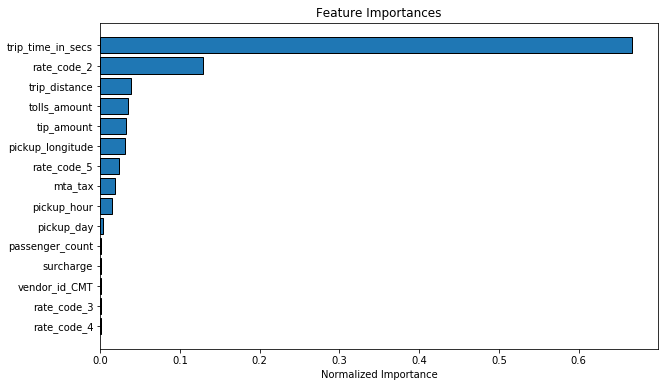

In [53]:
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances to add up to one
feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances.index[:15]))), 
feature_importances['importance_normalized'].head(15), align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
ax.set_yticklabels(feature_importances['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()

#### Third Model: XGBoost

In [54]:
xgb = XGBRegressor()
# fit the model
xgb.fit(x_train, y_train)

C:\Users\Nastaran\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:14:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [55]:
# predict 
y_pred = xgb.predict(x_test)

In [56]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % (rmse))

RMSE: 1.554


In [57]:
mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % (mae))

MAE: 0.518


In [58]:
#importance feature
feature_importance_values = xgb.feature_importances_

In [59]:
feature_importances = pd.DataFrame({'feature': list(x.columns), 'importance': feature_importance_values})


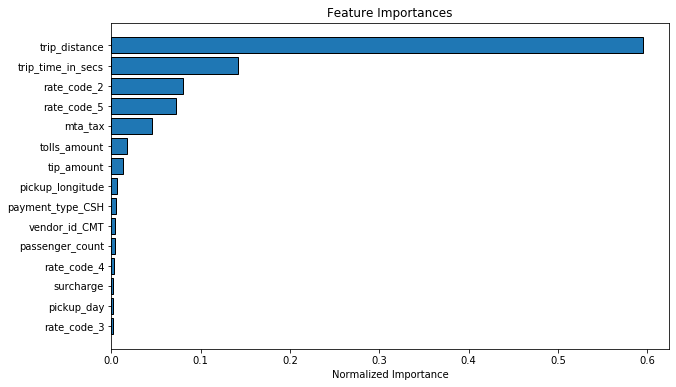

In [60]:
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances to add up to one
feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances.index[:15]))), 
feature_importances['importance_normalized'].head(15), align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
ax.set_yticklabels(feature_importances['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()